This notebook includes my code for my final individual project for Digital Humanities 100.

*Please note: This project includes lyrical analysis into explicit hip-hop content. This is purely for educational purposes and does not intend to be offensive. *

**Introduction:**

The music streaming industry has revolutionized the way music is consumed by listeners. In particular, it has has profoundly increased consumption of hip-hop tracks. Individual artists  hold significant influence over their careers, especially in a post-label market. Through platforms such as Soundcloud, Youtube, Spotify, Apple Music, Tidal, and Social Media platforms, each artist has the ability to connect and share their music with millions of fans across the world.  

The goal of this project is to understand how track lyrics and popularity have evolved over the last four years with the help of streaming services. 




In [1]:
!pip install -U -q PyDrive
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import random
import os
import re
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import random 
import os
import re

**Data Setup**

**Spotipy** is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform.

I am using Spotipy APIs to get streaming data and audio information for the top streaming tracks. 


In [59]:
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 
client_id = "fde3b9ca0af643d4ac5a9b4bd48c8ca9"
client_secret = "c093d503f15a4e7d991a6de6797e309a"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Here, I am installing the unofficial Spotify Charts API. It shows any and all data for top 200 and viral 50 music on Spotify. Here are the links to fycharts (https://pypi.org/project/fycharts/) & (https://github.com/kelvingakuo/fycharts#utils). 

**Fycharts** is "A fully-fledged installable python package for extracting top 200 and viral 50 charts off of spotifycharts.com"

In a nutshell, the unofficial Spotify Charts API.


In [60]:
!pip install fycharts

In [61]:
from fycharts.SpotifyCharts import SpotifyCharts
api = SpotifyCharts()

Initializing a global track list dataframe. This dataframe will be used for the analysis of tracks and testing my hypothesis. 

In [62]:
gtrack_list = pd.DataFrame()

The **top200Weekly** function is the main data extractor function for top streaming tracks. 

In this function, we are checking the following

1. If the charts data file (A) from 'start date` to `end date` exists 
2. Is the corrosponding spotify file (B) for the top 200 weekly songs from the above list exist. 
3. If B exist, we have all the data for the top 200 songs for start data and end data. We read B in a dataframe and return
4. If B doesn't exist, then check if A exist. If A exists, then read A. Else call the Charts API get the top 200 songs from the charts and write it to a file. 
5. Once we have read A, then for each song in the chart, call the spotify api, to get the details of the song, the audio features and then write all the data to an file , which will be the B file. Next time for the same start date and end date, we don't have to do this process, we can read directly off the file. 


In [63]:

def top200Weekly(start_date,end_date):
    # File from Spotify Charts.
    charts_file_name = "top_200_weekly_"+start_date+"_"+end_date+".csv"; 
    # File with Spotify data. 
    sp_file = "top_200_weekly"+start_date+"_"+end_date + "_sp.csv"; 
    if os.path.isfile(sp_file):
        track_list = pd.read_csv(sp_file)
    else:
        if os.path.isfile(charts_file_name):
            top200Weekly_df = pd.read_csv(charts_file_name)
        else: 
            api.top200Weekly(output_file = charts_file_name, 
                             start = start_date, end = end_date, region = ["us"])
            top200Weekly_df = pd.read_csv(charts_file_name)
        print(top200Weekly_df.shape)
        track_list = track_df(top200Weekly_df)
        track_list.to_csv(sp_file,index=False)
    return track_list



The Audion Features function extracts the audio features from Spotify for a track. The audio features I get are as follows: 

1.   Acousticness
2.   Danceability
3.   energy
4.   instrumentalness
5.   liveness
6.   loudness
7.   speechiness
8.   tempo
9.  valence



In [64]:
features = {}
def audio_features(uri):
    features = sp.audio_features(uri)
    return features

Additionally, for each track I am getting the following information from Spotify Charts and Spotify

1. Artist Name
2. Duration 
3. Album Release Date
4. Album Type
5. Album Name
6. Popularity
7. Position in the Weekly Charts
9. Number of Streams

In [65]:
import json
from pprint import pprint
def track_df(top200Weekly_df):
  track_dict = {}
  track_list = pd.DataFrame()
  for index, row in top200Weekly_df.head(10).iterrows(): 
      uri = row["spotify_id"]
      track_name = row["Track Name"]
      track_dict.update(row)
      urn = 'spotify:track:'+uri
      features = audio_features(urn)
      track_info = sp.track(uri)
      album_type = track_info['album']['album_type']
      release_date = track_info['album']['release_date']
      popularity = track_info['popularity']
      duration_ms = track_info['duration_ms']
      track_dict.update(features[0]) 
      track_dict.update({"album_type" : album_type, "release_date" : release_date, "popularity": popularity, "duration_ms":duration_ms })
      track_list = track_list.append(track_dict, ignore_index=True)
  print(track_list.shape)
  return track_list

For my project, For every quarter, I chose the top 10 from the top 200 songs from Spotify. I used the years 2017, 2018, 2019, and 2020

The reason I went with every quarter, is because the top songs in the charts remain in the charts for a quarter. 

I also save the songs dataframe CSV file, so I don't have to extract the data from the Spotify APIs every time I run the program. This saves a lot of time. 

In [66]:

## Jan 01, Apr 04, Jul 07, Oct 10
week_dates = [("2017-01-06","2017-01-31"),
                ("2017-04-07","2017-04-30"),
                ("2017-07-07","2017-07-31"),
                ("2017-10-06","2017-10-31"),
                ("2018-01-05","2018-01-31"),
                ("2018-04-06","2018-10-30"),
                ("2018-07-06","2018-10-31"),
                ("2018-10-05","2018-10-31"),
                ("2019-01-04","2019-01-31"),
                ("2019-04-05","2019-04-30"),
                ("2019-07-05","2019-07-31"),
                ("2019-10-04","2019-10-31"),
                ("2020-01-03","2020-01-31"),
                ("2020-02-07","2020-02-28"),
                ("2020-03-06","2020-03-27")
            ]
for start_date, end_date in week_dates:
    gtrack_list = gtrack_list.append(top200Weekly(start_date,end_date))
    gtrack_list.shape

## Understanding the Data
The data that you are seeing here is the artist, position, number of streams, audio features, album details, popularity, duration of the song, release date of the track. 

In [67]:
gtrack_list.shape
gtrack_list.sort_values(by=['Streams'],ascending=False)

,Artist,Position,Streams,Track Name,acousticness,album_type,analysis_url,danceability,date,duration_ms,...,region,release_date,speechiness,spotify_id,tempo,time_signature,track_href,type,uri,valence
0,Drake,1.0,24879464.0,In My Feelings,0.00623,album,https://api.spotify.com/v1/audio-analysis/0bAk...,0.735,2018-07-06--2018-07-13,217933.0,...,us,2018-06-29,0.1390,0bAkKNCQfWkexHFn7fIKns,181.995,4.0,https://api.spotify.com/v1/tracks/0bAkKNCQfWke...,audio_features,spotify:track:0bAkKNCQfWkexHFn7fIKns,0.3150
0,Lil Nas X,1.0,20673623.0,Old Town Road (feat. Billy Ray Cyrus) - Remix,0.05330,single,https://api.spotify.com/v1/audio-analysis/6u7j...,0.878,2019-04-05--2019-04-12,157066.0,...,us,2019-04-05,0.1020,6u7jPi22kF8CTQ3rb9DHE7,136.041,4.0,https://api.spotify.com/v1/tracks/6u7jPi22kF8C...,audio_features,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,0.6390
0,Travis Scott,1.0,20518547.0,HIGHEST IN THE ROOM,0.05460,single,https://api.spotify.com/v1/audio-analysis/3eek...,0.598,2019-10-04--2019-10-11,175720.0,...,us,2019-10-04,0.0317,3eekarcy7kvN4yt5ZFzltW,76.469,4.0,https://api.spotify.com/v1/tracks/3eekarcy7kvN...,audio_features,spotify:track:3eekarcy7kvN4yt5ZFzltW,0.0605
0,Roddy Ricch,1.0,18952305.0,The Box,0.10400,album,https://api.spotify.com/v1/audio-analysis/0nbX...,0.896,2020-01-03--2020-01-10,196652.0,...,us,2019-12-06,0.0559,0nbXyq5TXYPCO7pr3N8S4I,116.971,4.0,https://api.spotify.com/v1/tracks/0nbXyq5TXYPC...,audio_features,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,0.6420
0,Roddy Ricch,1.0,18883695.0,The Box,0.10400,album,https://api.spotify.com/v1/audio-analysis/0nbX...,0.896,2020-02-07--2020-02-14,196652.0,...,us,2019-12-06,0.0559,0nbXyq5TXYPCO7pr3N8S4I,116.971,4.0,https://api.spotify.com/v1/tracks/0nbXyq5TXYPC...,audio_features,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,0.6420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,XXXTENTACION,10.0,5612567.0,Jocelyn Flores,0.46900,album,https://api.spotify.com/v1/audio-analysis/7m9O...,0.872,2017-10-06--2017-10-13,119133.0,...,us,2017-08-25,0.2420,7m9OqQk4RVRkw9JJdeAw96,134.021,4.0,https://api.spotify.com/v1/tracks/7m9OqQk4RVRk...,audio_features,spotify:track:7m9OqQk4RVRkw9JJdeAw96,0.4370
6,Big Sean,7.0,5384798.0,Bounce Back,0.10600,album,https://api.spotify.com/v1/audio-analysis/0SGk...,0.780,2017-01-06--2017-01-13,222360.0,...,us,2017-02-03,0.1390,0SGkqnVQo9KPytSri1H6cF,81.502,4.0,https://api.spotify.com/v1/tracks/0SGkqnVQo9KP...,audio_features,spotify:track:0SGkqnVQo9KPytSri1H6cF,0.2730
7,Rae Sremmurd,8.0,5319110.0,Black Beatles,0.14200,album,https://api.spotify.com/v1/audio-analysis/6fuj...,0.794,2017-01-06--2017-01-13,291893.0,...,us,2016-08-12,0.0649,6fujklziTHa8uoM5OQSfIo,145.926,4.0,https://api.spotify.com/v1/tracks/6fujklziTHa8...,audio_features,spotify:track:6fujklziTHa8uoM5OQSfIo,0.3550
8,Aminé,9.0,5264976.0,Caroline,0.30300,single,https://api.spotify.com/v1/audio-analysis/5GFD...,0.945,2017-01-06--2017-01-13,209746.0,...,us,2016-08-26,0.4920,5GFDrUTLGJix84sNhjCG0g,120.058,4.0,https://api.spotify.com/v1/tracks/5GFDrUTLGJix...,audio_features,spotify:track:5GFDrUTLGJix84sNhjCG0g,0.7430


Sorting by duration of the tracks. Shortern songs does not necessarily mean that there is a lower number of streams. And conversely, longer songs don't have more number of streams. 

Additionally, more songs in 2019 and 2020 have shorter duration. 

In [68]:
gdf = gtrack_list.sort_values(by=['duration_ms'],ascending=True).drop_duplicates('Track Name', keep='last')
gdf[['Artist','Position','Track Name','date','duration_ms','Streams']].head(40)

,Artist,Position,Track Name,date,duration_ms,Streams
1,Lil Nas X,2.0,Old Town Road,2019-04-05--2019-04-12,113013.0,15186440.0
2,Lil Nas X,3.0,Panini,2019-07-05--2019-07-12,114893.0,9872012.0
9,XXXTENTACION,10.0,Jocelyn Flores,2017-10-06--2017-10-13,119133.0,5612567.0
5,Lil Pump,6.0,Gucci Gang,2017-10-06--2017-10-13,124055.0,6448847.0
5,Kanye West,6.0,I Love It (& Lil Pump),2018-10-05--2018-10-12,127946.0,7983540.0
6,Lil Tecca,7.0,Ransom,2019-07-05--2019-07-12,131280.0,7914144.0
7,XXXTENTACION,8.0,Moonlight,2018-07-06--2018-07-13,135090.0,8894448.0
4,Lil Baby,5.0,Drip Too Hard (Lil Baby & Gunna),2019-01-04--2019-01-11,145542.0,8917200.0
9,NLE Choppa,10.0,Camelot,2019-10-04--2019-10-11,148759.0,6084351.0
1,Post Malone,2.0,Wow.,2019-01-04--2019-01-11,149520.0,12721360.0


Getting all the columns in the dataframe for analysis

In [69]:
print(gtrack_list.keys())
gtrack_list['release_year'] = pd.to_datetime(gtrack_list['release_date'].astype(str),format="%Y-%m-%d").dt.year
gtrack_list.release_year.unique()

Index(['Artist', 'Position', 'Streams', 'Track Name', 'acousticness',
       'album_type', 'analysis_url', 'danceability', 'date', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'region', 'release_date', 'speechiness',
       'spotify_id', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')


array([2017, 2016, 2018, 2019, 2020])

Drop duplicate tracks from the Dataframe. The final track dataframe size is now 124 rows. 

In [70]:
gtrack_list_unique = gtrack_list.drop_duplicates('Track Name', keep='last')
gtrack_list_unique.shape

(124, 29)

## Analysis

Firt we are importing seaborn and matplotlib for our data visualizations. 

We group the tracks by release year and find the min, max and mean duration of the tracks in minutes. We plot the data and we see the duration is dropping over the last 4 years. We don't have all the data for 2020, hence the dataset plot in not complete for 2020.  

<Figure size 1080x576 with 0 Axes>

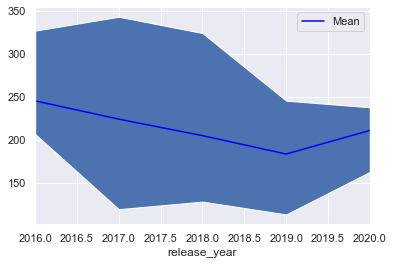

In [71]:
import matplotlib.pyplot as plt
duration_m_data = gtrack_list_unique
duration_m_data['duration_m'] = duration_m_data['duration_ms'].apply(lambda x: x/1000)
duration_m_data = duration_m_data.groupby('release_year')['duration_m'].agg(Low='min',High='max',Mean='mean')
duration_m_data.reset_index(inplace=True)
plt.figure(figsize=(15,8))
ax  = duration_m_data.plot(x='release_year', y='Mean', c='blue')
plt.fill_between(x='release_year',y1='Low',y2='High', data=duration_m_data) 

In [72]:
import seaborn as sns; 
sns.set()


### Genre fluidity and Audio analysis.

According to my hypothesis, because of streaming and the way songs are consumed, the songs have more dancibility and liveness, irrespective of the genre the songs belong[link text](https://) to (ie Hip Hop, Pop etc. )

All 150 songs over the 4 years. 

Text(0, 0.5, 'Rating')

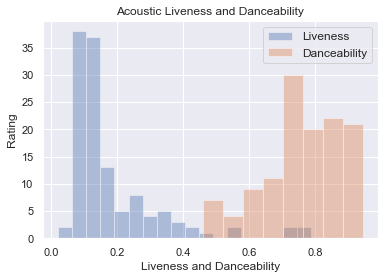

In [73]:
sns.set(color_codes=True)
sns.distplot(gtrack_list_unique['liveness'],  kde=False,label='Liveness')
sns.distplot(gtrack_list_unique['danceability'],  kde=False, label='Danceability')
plt.legend(prop={'size': 12})
plt.title('Acoustic Liveness and Danceability')
plt.xlabel('Liveness and Danceability')
plt.ylabel('Rating')

Next, I would like to see the change in liveleness and tempo over the years using the box plot. This graph compares release_year and liveleness of the same songs and we see there are some outliers, but the average liveleness is increasing over the years. Also the variation in liveliness (size of the box) is almost similar, which means all songs trying to get to the same level of liveliness, irrespective of the genre. 

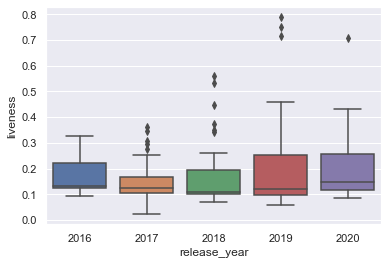

In [74]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
ax = sns.boxplot(y="liveness", x="release_year", data=gtrack_list_unique)
plt.show()

This graph compares release_year and tempo of the same songs and we see the average tempo is increasing over the years. Also the variation in tempo (size of the box) is reducing, which means songs trying to get higher tempo to increase their popularity. 



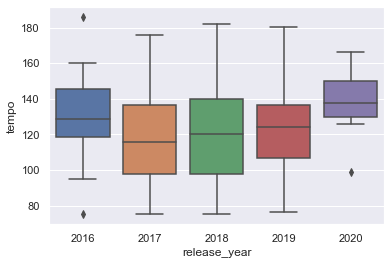

In [19]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
ax = sns.boxplot(y="tempo", x="release_year", data=gtrack_list_unique)
plt.show()

This scatter plot graph looks at the danceability of the songs with the number of streams. We can visualize the the songs are clustered with a mean danceability of 0.7-0.9, for streams of 0.75-1.0 m . 


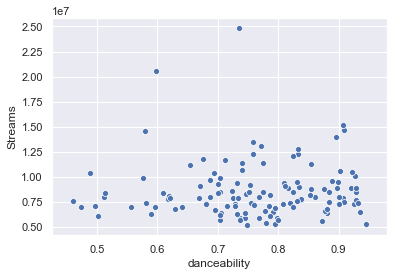

In [75]:
ax = sns.scatterplot(y="Streams", x="danceability", data=gtrack_list_unique)
ax.locator_params(integer=True)
plt.show()

This scatter plot graph looks at the speechiness of the songs with the number of streams. We can visualize songs are less speechy, which could be more beats and repetition of lyrics. 

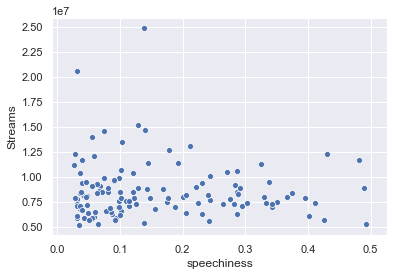

In [76]:
ax = sns.scatterplot(y="Streams", x="speechiness", data=gtrack_list_unique)
ax.locator_params(integer=True)
plt.show()

## End Genre fluidity and Audio analysis.

Using the data from Spotify charts, streams, positions and audio features, we are able to arrive at the conclusion that irrespective of genres, the songs are getting smaller for higher number of streaming, and the audio analysis shows that songs want to have the similar audio characteristics in order to maintain their chart positions.

## Lyrical Analysis

Here, we are using a selected four random songs from the top streaming songs and pulling the lyrics from genius and beautifulsoup for lyrical analysis. 

The approach to lyrical analysis is as follows. 

1. Data extraction
   - Genius API to pull the lyrics for the tracks
   - Beautiful soup to parse the content 
   - Create a dataframe with the artist name, track name, lyrics
   - Save the dataframe to csv file.

2. Data preparation
  - Removing stopwords
  - Stemming, 
  - Removing punctuations, 
  - and then tokenizing them.

3. Use Wordcloud to visualize Top 25 Words in Songs 

4. Topic Modeling using TF-IDF Vectorizer
  - Extract the top features
  - Rank them based on the scores
  - Use LDA to do Topic Modeling, to extract the main topics
  - Use NMF to do Topic Modeling

5. Cosine Similarity
   Similarity of the tracks in a 4x4 matrix 

In [23]:
import requests
from bs4 import BeautifulSoup
defaults = {
    'request': {
        'token': 'i507Djjp1UurKonxzH_iyuCAP1Af_zSAjQ_eM7fZDV_ucIoEIhACnGMU3tT6IhDz',
        'base_url': 'https://api.genius.com'
    },
    'message': {
        'search_fail': 'The lyrics for this song were not found!',
        'wrong_input': 'Wrong number of arguments.\n' \
                       'Use two parameters to perform a custom search ' \
                       'or none to get the song currently playing on Spotify.'
    }
}

In [24]:
def request_song_info(song_title, artist_name):
    base_url = defaults['request']['base_url']
    headers = {'Authorization': 'Bearer ' + defaults['request']['token']}
    search_url = base_url + '/search'
    data = {'q': song_title + ' ' + artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    return response

In [25]:
def scrap_song_url(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    [h.extract() for h in html('script')]
    lyrics = html.find('div', class_='lyrics').get_text()
    return lyrics

In [26]:
def get_song_lyrics(song_title,artist_name):
    lyrics_dict= {}
    lyrics_df = pd.DataFrame()
    response = request_song_info(song_title, artist_name)
    json = response.json()
    for hit in json['response']['hits']:
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
            remote_song_info = hit
            break
    # Extract lyrics from URL if song was found
    if remote_song_info:
        song_url = remote_song_info['result']['url']
        lyrics = scrap_song_url(song_url)
        lyrics_dict.update({"artist_name" : artist_name, "song_title" : song_title, "lyrics": lyrics})
        lyrics_df = lyrics_df.append(lyrics_dict, ignore_index=True)
        ly_file = song_title+"_"+artist_name+".csv"; 
        lyrics_df.to_csv(ly_file,index=False)
    else:
        print(defaults['message']['search_fail'])
    return lyrics_df


In [27]:
song_list = [("The Box","Roddy Ricch"),("Gucci Gang","Lil Pump"),("Bodak Yellow","Cardi B"),("Fake Love","Drake")]
# Search for matches in request response
all_lyrics_df = pd.DataFrame()
for song_title, artist_name in song_list:
    # File with Lyrics data. 
    ly_file = song_title+"_"+artist_name+".csv"; 
    if os.path.isfile(ly_file):
        lyrics_df = pd.read_csv(ly_file)
    else:
        lyrics_df = get_song_lyrics(song_title,artist_name)
    all_lyrics_df = all_lyrics_df.append(lyrics_df, ignore_index=True)
print(all_lyrics_df.shape)

(4, 3)


In [28]:
all_lyrics_df

,artist_name,lyrics,song_title
0,Roddy Ricch,\n\n[Chorus]\nPullin' out the coupe at the lot...,The Box
1,Lil Pump,"\n\n[Intro]\nYuh, ooh, brr, brr\nGucci gang, o...",Gucci Gang
2,Cardi B,"\n\n[Intro]\nKSR\nIt's Cardi, ayy\nSaid I'm th...",Bodak Yellow
3,Drake,"\n\n[Chorus]\nI've been down so long, it look ...",Fake Love


In [29]:
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('names')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/rajesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/rajesh/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /Users/rajesh/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rajesh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [30]:
# Remove punctuations stop words from the verdict transcript text, before tokenzing, stemming and chunking it. 
from nltk.corpus import stopwords
from string import punctuation
def rem_punc_stop(text):
    
    from string import punctuation
    from nltk.corpus import stopwords,words
    stop_words = set(stopwords.words("english"))
    punctuation = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punctuation])
    
    words = nltk.word_tokenize(punc_free)
    noise_free = [word for word in words if word not in stop_words]
    
    return noise_free


In [31]:
snowball = nltk.SnowballStemmer('english')

In [32]:
# Lower case and stem the words 
def does_it_all(text):
    tokens = ""
    not_stemmed = rem_punc_stop(text)
    for word in not_stemmed:
        tokens += snowball.stem(word.lower()) + " "    
    return tokens

In [33]:
all_lyrics_df['tokens'] = all_lyrics_df['lyrics'].apply(does_it_all)
all_lyrics_df['tokens']

0    chorus pullin coup lot told em fuck 12 fuck sw...
1    intro yuh ooh brr brr gucci gang ooh that righ...
2    intro ksr it cardi ayi said im shit cant fuck ...
3    chorus ive long look like they look i got fake...
Name: tokens, dtype: object

In [34]:
def to_string(tokens): 
    string = ""
    for i in tokens:
        string = string + " " +i
    return string

We have made a wordcloud with the top 25 words in the four songs. 

In [35]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


<function matplotlib.pyplot.show(*args, **kw)>

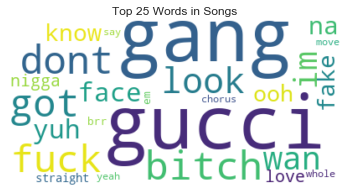

In [77]:
from wordcloud import WordCloud
wordcloud_lyrics = WordCloud(max_words = 25, background_color = "white", collocations=False).generate(to_string(all_lyrics_df["tokens"]))
plt.imshow(wordcloud_lyrics, interpolation='bilinear')
plt.axis("off")
plt.title('Top 25 Words in Songs')
plt.show

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import itertools
import seaborn as sn
%matplotlib inline

In [79]:
import re, string
re_tok = re.compile(f'([{string.punctuation}""¨«»®´·º½¾¿¡§£₤''])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Text modeling. This takes the tokens and performs textual frequency analysis. This gives context to the vector. 

In [80]:
tf = TfidfVectorizer(analyzer='word', 
                     tokenizer=tokenize,
                     ngram_range=(1,2), 
                     max_df=0.95, min_df=2,
                     use_idf=1,
                     smooth_idf=1,
                     sublinear_tf=1,
                     strip_accents='unicode',
                     stop_words = 'english')


In [81]:
token_list = all_lyrics_df['tokens']
token_list

0    chorus pullin coup lot told em fuck 12 fuck sw...
1    intro yuh ooh brr brr gucci gang ooh that righ...
2    intro ksr it cardi ayi said im shit cant fuck ...
3    chorus ive long look like they look i got fake...
Name: tokens, dtype: object

This list provides a feature extration. 

In [82]:
tfidf_matrix = tf.fit_transform(token_list)
feature_names = tf.get_feature_names()
feature_names

['1',
 '2',
 'aint',
 'ayi',
 'bag',
 'bitch',
 'bitch make',
 'bought',
 'buy',
 'came',
 'dont',
 'em',
 'face',
 'flyin',
 'forgot',
 'fuck',
 'got',
 'got ta',
 'hand',
 'heard',
 'hit',
 'ill',
 'im',
 'intro',
 'know',
 'know nigga',
 'lil',
 'lil bitch',
 'live',
 'look',
 'look like',
 'love',
 'make',
 'na',
 'new',
 'nigga',
 'play',
 'pop',
 'privat',
 'pussi',
 'real',
 'realli',
 'red',
 'right',
 'rolli',
 'run',
 'safe',
 'say',
 'say dont',
 'sell',
 'shoe',
 'skrrt',
 'son',
 'speak',
 'street',
 'ta',
 'tell',
 'time',
 'tryna',
 'vers 1',
 'vers 2',
 'wan',
 'wan na',
 'whip',
 'wont',
 'yeah',
 'yeah know']

Here, we are performing analysis on these features, to provide scoring about the contentuxal frequency of the words. 

In [83]:
dense = tfidf_matrix.todense()

document = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(document)), document) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
high_score_phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
   print('{0: <20} {1}'.format(phrase, score))
   high_score_phrases.append(phrase)

nigga                0.3010986202517112
got                  0.2656989632737475
got ta               0.2457438118785577
ta                   0.2457438118785577
em                   0.23478517713988623
fuck                 0.21285149681948762
yeah                 0.21285149681948762
know                 0.19895079488087003
hit                  0.1976368094504374
im                   0.1976368094504374
realli               0.1976368094504374
sell                 0.1976368094504374
wont                 0.1976368094504374
wan                  0.18193771068562636
na                   0.16000403036522778
say                  0.16000403036522778
wan na               0.16000403036522778
ill                  0.15945213344206802
bitch                0.12909024423136647
bag                  0.09417499864916361
bought               0.09417499864916361
flyin                0.09417499864916361
hand                 0.09417499864916361
know nigga           0.09417499864916361
pop                  0.09

In [43]:
!pip install gensim

In [84]:
from gensim.models import ldamodel
import gensim.corpora;
import pickle;
from sklearn.decomposition import NMF, LatentDirichletAllocation
feature_names_d = [d.split() for d in feature_names]
id2word = gensim.corpora.Dictionary(feature_names_d)

In [85]:
corpus = [id2word.doc2bow(text) for text in feature_names_d]
num_topics = 10
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [86]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [47]:
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.074*"em" + 0.074*"right" + 0.074*"say" + 0.074*"play" + 0.074*"hit" + 0.074*"real" + 0.074*"live" + 0.074*"whip" + 0.074*"buy" + 0.007*"know"
Topic: 1 
Words: 0.176*"1" + 0.092*"vers" + 0.092*"know" + 0.092*"realli" + 0.092*"ayi" + 0.008*"lil" + 0.008*"make" + 0.008*"say" + 0.008*"na" + 0.008*"look"
Topic: 2 
Words: 0.085*"dont" + 0.085*"sell" + 0.085*"safe" + 0.085*"face" + 0.085*"forgot" + 0.085*"make" + 0.085*"im" + 0.008*"look" + 0.008*"know" + 0.008*"ta"
Topic: 3 
Words: 0.092*"dont" + 0.092*"say" + 0.092*"run" + 0.092*"aint" + 0.092*"son" + 0.092*"ill" + 0.008*"lil" + 0.008*"got" + 0.008*"look" + 0.008*"make"
Topic: 4 
Words: 0.141*"wan" + 0.074*"na" + 0.074*"got" + 0.074*"ta" + 0.074*"pop" + 0.074*"tell" + 0.074*"bought" + 0.074*"love" + 0.007*"know" + 0.007*"look"
Topic: 5 
Words: 0.065*"2" + 0.065*"vers" + 0.065*"rolli" + 0.065*"ta" + 0.065*"got" + 0.065*"pussi" + 0.065*"street" + 0.065*"came" + 0.065*"flyin" + 0.065*"red"
Topic: 6 
Words: 0.173*"bitch" + 0.

In [87]:
get_lda_topics(lda, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,lil,forgot,1,know,bitch,dont,wan,vers,ill,dont
1,ta,bought,vers,nigga,make,say,look,2,know,got
2,bitch,make,heard,yeah,tell,hit,like,face,play,yeah
3,came,bitch,realli,na,live,skrrt,na,privat,whip,tryna
4,red,know,love,look,know,intro,2,fuck,street,speak
5,ayi,yeah,lil,aint,got,son,run,hand,em,time
6,flyin,got,bitch,pop,lil,buy,safe,bitch,rolli,sell
7,right,lil,make,say,na,got,new,lil,pussi,make
8,got,nigga,say,bitch,dont,ta,bag,na,say,lil
9,know,say,got,got,2,know,shoe,wan,bitch,nigga


In [49]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 1.1MB/s 
     |████████████████████████████████| 552kB 57.7MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=174fdb3da44eb55960ed57591fa4403b3e860e9c27c0c240c30bc6768e22bcd3
  Stored in directory: /Users/rajesh/Library/Caches/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=a1deae91b20c76d8eabbd90bb69c0be38b3de690cc2aa711ccf598d3c47dffd8
  Stored in directory: /Users/rajesh/Library/Caches/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [88]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.155853 -0.090811       1        1  13.874483
0     -0.147705 -0.038420       2        1  12.575568
3      0.101270  0.124092       3        1  11.926412
5     -0.059573  0.070956       4        1  10.538348
7      0.026548 -0.081235       5        1   9.545430
8      0.029299  0.073514       6        1   9.112583
2     -0.001841 -0.063537       7        1   8.896111
9     -0.038421  0.072594       8        1   8.769100
4     -0.057050 -0.046248       9        1   8.246816
1     -0.008380 -0.020906      10        1   6.515158, topic_info=   Category      Freq   Term     Total  loglift  logprob
5   Default  2.000000  bitch  2.000000  30.0000  30.0000
0   Default  1.000000      1  1.000000  29.0000  29.0000
6   Default  1.000000   make  1.000000  28.0000  28.0000
24  Default  2.000000   know  2.000000  27.0000  27.0000
25  Default  1.000000  nigga  1.000000  26.0000  26.0000
..      ...       ...    ...       ...      ...      ...
10  Topic10  0.056385   dont  1.676742  -0.6614  -4.4883
0   Topic10  0.056384      1  1.718687  -0.6861  -4.4883
40  Topic10  0.056383  right  1.174694  -0.3056  -4.4884
55  Topic10  0.056382    wan  1.641333  -0.6401  -4.4884
3   Topic10  0.056382    ayi  1.174700  -0.3056  -4.4884

[488 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         7  0.581840     1
1         1  0.580713     2
1         5  0.580713     2
2         3  0.873297  aint
3         2  0.851281   ayi
...     ...       ...   ...
55        1  0.609261   wan
56        6  0.932530  whip
57        1  0.905450  wont
58        3  0.599328  yeah
58        8  0.599328  yeah

[69 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 6, 8, 9, 3, 10, 5, 2])

In [51]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
num_topics = 10
nmf_1832 = NMF(n_components=num_topics, random_state=1).fit(tfidf_matrix)
nmf_1832

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [52]:
def display_topics(model, feature_names, num_top_words):
    """Displays NUM_TOP_WORDS topics for MODEL """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
# the number of words to display per topic
num_top_words = 10
# display the topics for 1822
display_topics(nmf_1832, feature_names, num_top_words)

Topic 0:
got nigga im ta know got ta hit wan na na fuck
Topic 1:
face look love time wan na na wan look like right got
Topic 2:
sell yeah nigga realli wont em bought flyin privat got ta
Topic 3:
bitch buy new lil fuck forgot ayi love red intro
Topic 4:
dont make bitch ayi red lil lil bitch play time face
Topic 5:
love right buy fuck yeah new forgot ayi sell bitch
Topic 6:
wont yeah know skrrt realli yeah son wan got 2 vers 1
Topic 7:
love face came right heard time look na wan look like
Topic 8:
make bitch make pussi speak lil bitch lil say dont shoe safe red
Topic 9:
buy fuck bitch em lil forgot flyin bought right live


In [53]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
cosine_similarity(tfidf_matrix[0:2], tfidf_matrix)
cosine_similarity(tfidf_matrix[0:3], tfidf_matrix)
cosine_similarity(tfidf_matrix[0:4], tfidf_matrix)

array([[1.        , 0.22326383, 0.65589688, 0.43790093],
       [0.22326383, 1.        , 0.43458049, 0.12994404],
       [0.65589688, 0.43458049, 1.        , 0.47090538],
       [0.43790093, 0.12994404, 0.47090538, 1.        ]])

# End of Lyrical Analysis
The topic modeling of the lyrics shows topics which are top 10 topics , keywords for each topic and the weightage(importance) of each keyword and words which are closer to other words in the topic.



# Conclusion

From these visualizations and interpretations, I hope viewers can gain an understanding about the the impact the streaming industry has had on musical development - both from the production and lyrical sides. The streaming industry has given artists creative control over their tracks and marketing. Artists now have data about the type of content their fans want to listen to and where their fans are listening from.

Furthermore, the two questions that I set out to answer were: 

1. How has music’s sound and genre fluidity evolved since the prominence of the streaming industry? 
2. How has the lyrical components and musical themes changed since the prominence of the streaming industry?

In response to the first question, music’s sound has changed with an emphasis on beats. Songs are shorter in length and albums have more tracks. Genre lines are no longer clearly defined as artists are more versatile in their craft. 

In response to the second question, musical themes and lyrical components have changed as artists prefer repetetion, increased danceability, and liveliness in their sounds. The song topics and themes are quite similar (as seen in the topic modeling above).


In the future, I would like to add a sentiment analysis component. I would add tweets about a specific track and compare it to critics’ reviews. I would love to go forward with this project and would welcome any feedback! 


Contact: rishabhparekh@berkeley.edu

